In [52]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots,cm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize,
poly)
from sklearn.metrics import accuracy_score
from ISLP import confusion_table
from ISLP.models import contrast

import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
    (RandomForestClassifier as RF,
     GradientBoostingClassifier as GBR)
from ISLP.bart import BART
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_estimator
import scipy.stats as stats
from sklearn.preprocessing import scale

In [123]:
from imblearn.over_sampling import SMOTE

In [80]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
model = MS(train.columns.drop(["ID","Age","Customer_Churn"]),intercept=False)
D = model.fit_transform(train)
feature_names = list(D.columns)
x_train = np.asarray(D)
y_train = train["Customer_Churn"]
model1 = MS(test.columns.drop(["ID","Age","Customer_Churn"]),intercept=False)
D1 = model1.fit_transform(test)

x_test = np.asarray(D1)
y_test = test["Customer_Churn"]
x_train_scaled = scale(x_train)
x_test_scaled = scale(x_test)


In [229]:
smote = SMOTE( random_state=0)
X_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [56]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
model_new = MS(train.columns.drop(["ID","Customer_Churn"]),intercept=False)
D_new = model_new.fit_transform(train)
feature_names = list(D_new.columns)
x_train_new = np.asarray(D_new)
y_train = train["Customer_Churn"]
model1_new = MS(test.columns.drop(["ID","Customer_Churn"]),intercept=False)
D1_new = model1_new.fit_transform(test)

x_test_new = np.asarray(D1_new)
y_test = test["Customer_Churn"]
x_train_scaled = scale(x_train_new)
x_test_scaled = scale(x_test_new)

In [3]:
x_train = train[["AI_Interaction_Level", "Satisfaction_with_AI_Services"]]
x_test = test[["AI_Interaction_Level", "Satisfaction_with_AI_Services"]]
y_train =train["Customer_Churn"]
y_test = test["Customer_Churn"]

In [268]:
cols = ['Satisfaction_with_AI_Services', 'AI_Personalization_Effectiveness', 'AI_Response_Time', 
        'Overall_Usage_Frequency', 'Customer_Service_Interactions', 'Change_in_Usage_Patterns', 'Customer_Churn']
training1 = train[cols]
testing1 = test[cols]

# Separate features and target variable
x_train = training1.drop(['Customer_Churn'], axis=1)
y_train = training1['Customer_Churn']
x_test = testing1.drop(['Customer_Churn'], axis=1)
y_test = testing1['Customer_Churn']


In [269]:
rbf = SVC(kernel="rbf",gamma=1,C=10)
rbf.fit(x_train,y_train)

SVC(C=10, gamma=1)

In [270]:
y_hat_test = rbf.predict(x_test)
confusion_table(y_hat_test,y_test)

Truth,0,1
Predicted,,
0,621,191
1,93,345


In [271]:
accuracy = accuracy_score(y_test, y_hat_test)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 77.28%


In [282]:
rbf = SVC(kernel="rbf",gamma=10,C=1)
rbf.fit(x_train,y_train)
y_hat_test = rbf.predict(x_test)
confusion_table(y_hat_test,y_test)
accuracy = accuracy_score(y_test, y_hat_test)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 78.72%


In [284]:
test_ids = test['ID']
predictions_df = pd.DataFrame({
    'ID': test_ids,
    'Prediction': y_hat_test
})

# Convert the 'Prediction' column to float
predictions_df['Prediction'] = predictions_df['Prediction'].astype('double')

predictions_df.to_csv('predictions.csv', index=False)



In [285]:
merged_df = pd.merge(test[["ID","Customer_Churn"]], predictions_df, on='ID')
# Assuming the actual outcomes are in a column named 'Actual_Outcome'
# Count how many predictions match the actual outcomes
correct_predictions = (merged_df['Customer_Churn'] == merged_df['Prediction']).sum()

print(f"Number of correct predictions: {correct_predictions}")
print(f"Total predictions made: {len(merged_df)}")
accuracy = correct_predictions / len(merged_df)
print(f"Accuracy: {accuracy:.2%}")

Number of correct predictions: 984
Total predictions made: 1250
Accuracy: 78.72%


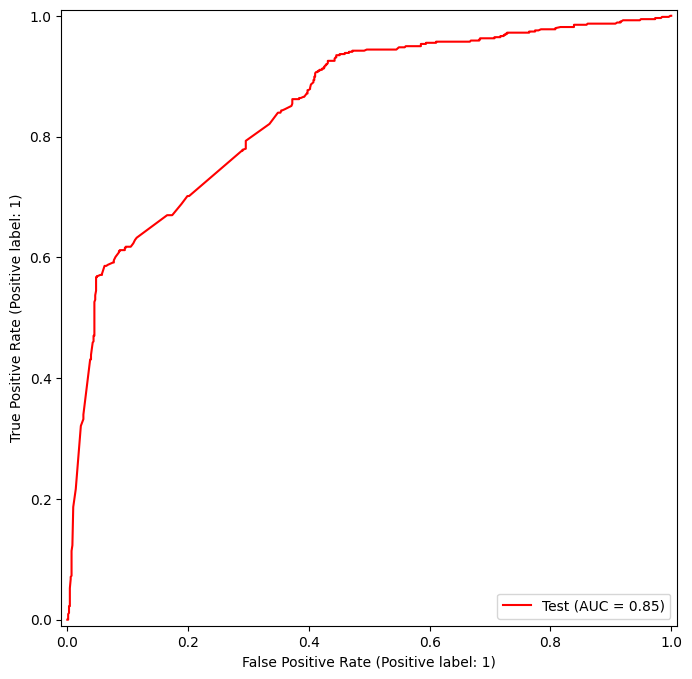

In [280]:
fix, ax = subplots(figsize=(8,8))
roc_curve(rbf,x_test,y_test,name="Test",color="r",ax=ax)

In [273]:
kfold     =     skm. KFold (5,
random_state =0, 
shuffle =True)
grid     =     skm. GridSearchCV ( rbf,
{ 'C':[0.1 ,1 ,10 ,100 ,1000] , 
'gamma':[0.5 ,1 ,2 ,3 ,4]} ,
refit =True , 
cv = kfold ,
scoring ='accuracy')
grid .fit( x_train ,   y_train) 
grid . best_params_

{'C': 0.1, 'gamma': 0.5}

In [12]:
best_svm     =     grid. best_estimator_
y_hat_test     =     best_svm . predict (x_test ) 
confusion_table (y_hat_test ,     y_test)


Truth,0,1
Predicted,,
0,714,536
1,0,0


In [13]:
accuracy = accuracy_score(y_test, y_hat_test)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 57.12%


In [15]:
from sklearn.model_selection import RandomizedSearchCV


param_distributions = {
    'C': stats.uniform(0.1, 1000),  # Uniform distribution between 0.1 and 1000.1
    'gamma': stats.uniform(0.5, 3.5)  # Uniform distribution between 0.5 and 4
}
kfold = skm.KFold(5, random_state=0, shuffle=True)
svm_rbf = SVC(kernel='rbf')

random_search = RandomizedSearchCV(
    svm_rbf, 
    param_distributions=param_distributions, 
    n_iter=100,  # Number of parameter settings that are sampled
    cv=kfold, 
    scoring='accuracy', 
    refit=True, 
    random_state=0,
    verbose=2,
    n_jobs=-1
)
random_search.fit(x_train, y_train)
print("Best parameters found: ", random_search.best_params_)

# You can also access the best score directly
print("Best score: ", random_search.best_score_)

# Best estimator (model) after refit
best_model = random_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'C': 548.9135039273248, 'gamma': 3.0031627823034683}
Best score:  0.5808


In [20]:
svm_new     =     SVC( kernel ="rbf",gamma=5,C=1000) 
svm_new .fit(x_train ,     y_train )
y_hat_test     =    svm_new . predict (x_test ) 
confusion_table (y_hat_test ,     y_test)

Truth,0,1
Predicted,,
0,708,407
1,6,129


In [21]:
accuracy = accuracy_score(y_test, y_hat_test)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 66.96%


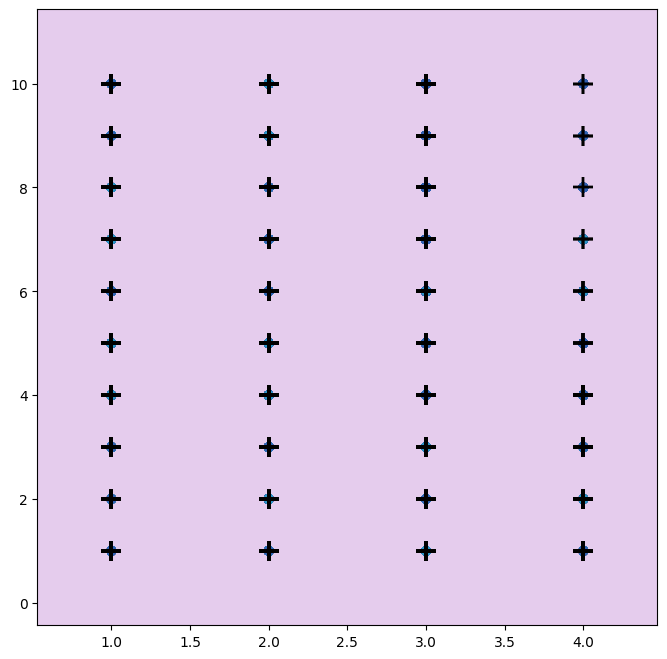

In [29]:
svm_linear = SVC(C=10,kernel="poly")
svm_linear.fit(x_train,y_train)
fix,ax = subplots(figsize=(8,8))
plot_svm(x_train,y_train,svm_linear,ax=ax)

In [30]:
kfold     =     skm. KFold (5,
random_state =0, 
shuffle =True)
grid     =     skm. GridSearchCV ( svm_linear ,
{ 'C':[0.001 ,0.01 ,0.1 ,1 ,5 ,10 ,100]} , 
refit =True ,
cv = kfold ,
scoring ='accuracy')
grid .fit(x_train,    y_train) 
grid . best_params_

{'C': 1}

In [31]:

best = grid.best_estimator_
y_test_hat     =   best.predict (x_test ) 
confusion_table (y_test_hat ,     y_test)

Truth,0,1
Predicted,,
0,714,536
1,0,0


In [32]:
accuracy = accuracy_score(y_test, y_hat_test)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 66.96%
